In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import random
p = 0.001  # 1% of the lines
# keep the header, then take only 10% of lines
# if random from [0,1] interval is greater than 0.1 the row will be skipped
df = pd.read_csv(
         'learning_traces.13m.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12765 entries, 0 to 12764
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   p_recall           12765 non-null  float64       
 1   timestamp          12765 non-null  datetime64[ns]
 2   delta              12765 non-null  int64         
 3   user_id            12765 non-null  object        
 4   learning_language  12765 non-null  object        
 5   ui_language        12765 non-null  object        
 6   lexeme_id          12765 non-null  object        
 7   lexeme_string      12765 non-null  object        
 8   history_seen       12765 non-null  int64         
 9   history_correct    12765 non-null  int64         
 10  session_seen       12765 non-null  int64         
 11  session_correct    12765 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 1.2+ MB


#### feature engineering

In [ ]:
# before we try to learn good values for theta 
# we need to construct x

# x = information a students history learning a certain word

df.iloc[0,:]

In [ ]:
# (df['p_recall'] == (df['session_correct'])/(df['session_seen'])).sum() == df.shape[0]

# p_recall is the ratio of session_correct/session_seen

# p_recall is "y" "ground truth"

# predicted_p_recall is "y_hat" "prediction"

# error(p_recall,predicted_p_recall) <- we want this to be as small as possible

# if we can very reliably predict p_recall, what is the value of this in real-life terms?


In [ ]:
# get parts of speech

def lexeme_df(filename):

    import re
    df_single_col = pd.read_csv(filename, delimiter='\t', header=None, names=['line'])

    def split_line(line):
        parts = re.split(r'\s+', line, maxsplit=2)
        if len(parts) == 3:
            return parts
        return [None, None, None]

    df_split = df_single_col['line'].apply(split_line)
    df = pd.DataFrame(df_split.tolist(), columns=['lexeme', 'category', 'meaning'])

    return df

In [ ]:
lexemes = lexeme_df('lexeme_reference.txt')
lexemes.head()

In [ ]:
lexemes['lexeme'].nunique()

In [ ]:
# one-hot encoding
# dummy variables / indicator variables

# df.loc[0,"lexeme_string"]

"<det><def><nt><sg><nom>"

# det, df, nt, sg, nom + 87 more 

# word | det | def | nt | sg | nom | ...
# das  |  1  | 1   | 1  | 1  |  1  | 0 ...



# look for the first <, remove everything to the left
# then remove <, >

# 

def extract_right_of_lt(text):
    import re
    match = re.search(r'<(.*)', text)
    return match.group(1) if match else ''




In [ ]:
df['lexeme_string'] = df['lexeme_string'].apply(extract_right_of_lt)
df['lexeme_string'] = df['lexeme_string'].str.replace("<"," ")
df['lexeme_string'] = df['lexeme_string'].str.replace(">","")
df['lexeme_string'] = df['lexeme_string'].str.replace("*","")
df['lexeme_string'] = df['lexeme_string'].str.replace("/","")
df['lexeme_string']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x.split(), binary=True)
vectorized_words = vectorizer.fit_transform(df['lexeme_string'])
vectorized_df = pd.DataFrame(vectorized_words.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

In [ ]:
# no longer optimizing this for now,
# i want to talk about specifying the model
# we'll return to this

vectorized_df.head()

In [ ]:
vectorized_df.sum().sort_values()

In [ ]:
# curious about most common parts of speech.
# how different parts of speech correspond to rate of correct responses

#
vectorized_df.sum().sort_values(ascending=False)[0:20].plot(kind = "bar",title="most common parts of speech")
plt.show()


In [ ]:
# p_recall 

df = pd.concat([df,vectorized_df],axis=1)
df.shape

In [ ]:
df.drop(columns = ['lexeme_string'],inplace=True)

In [ ]:
grp_by_columns = list(df.columns[~df.columns.isin(['p_recall','delta','user_id','timestamp',"history_seen", "history_correct", "session_seen",  "session_correct"])])

"""
select avg(p_recall)
from df
group by var1

select avg(p_recall)
from df
group by var2

...

select avg(p_recall)
from df
group by varn

"""

"""

select avg(p_recall)
from df
group by var1, ..., varn

"""

# 1515 binary vectors (one for each part of speech)

# 0 avg(p_recall)
# 1 avg(p_recall)

# df.drop(columns = grp_by_columns).mean(axis=1)



# df[grp_by_columns].mean(axis = 1)

list_of_recall_variation_by_column = []

for col in grp_by_columns:

    variation_of_means = df.groupby(col)['p_recall'].mean().std()

    variation_dict = {"column_name":col,
                      "variation_of_means":variation_of_means}

    list_of_recall_variation_by_column.append(variation_dict)

recall_variation_by_column = pd.DataFrame(list_of_recall_variation_by_column)
    
# col_name, std of group means

#### fitting

In [3]:
# should start with a really simple feature vector
# (history_seen, history_correct)

# decision: recode delta to days (that's what duolingo did)
# round to one decimal point

simple_df = df[['p_recall','delta','history_seen','history_correct']]
simple_df["delta_days"] = np.round(simple_df.loc[:,"delta"].copy()/(60*60*24),1)
simple_df.drop(columns = ["delta"],inplace=True)
simple_df.loc[simple_df["p_recall"] == 0,"p_recall"] = simple_df.loc[simple_df["p_recall"] == 0,"p_recall"] + 1e-3

# h
# -delta/log2(p)
simple_df["h"] = -1*simple_df["delta_days"]/(np.log2(simple_df["p_recall"]) + 1e-3)

# original error = (p_recall - predicted_p_recall)**2
# then the team at duolingo found out that their model performed better if they made the error function a little bit more complicated
# new error = (p_recall - predicted_p_recall)**2 + (half_life - predicted_half_life)**2

simple_df.sample(5)

# input_dim = 2

/var/folders/g7/wg003dgd7td2scfxtm9wznth0000gn/T/ipykernel_13680/2348582869.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_df["delta_days"] = np.round(simple_df.loc[:,"delta"].copy()/(60*60*24),1)
/var/folders/g7/wg003dgd7td2scfxtm9wznth0000gn/T/ipykernel_13680/2348582869.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_df.drop(columns = ["delta"],inplace=True)
/var/folders/g7/wg003dgd7td2scfxtm9wznth0000gn/T/ipykernel_13680/2348582869.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,p_recall,history_seen,history_correct,delta_days,h
8997,1.0,4,3,1.1,-1100.0
12643,1.0,5,4,0.0,-0.0
8218,1.0,3,3,1.0,-1000.0
9124,1.0,30,29,0.0,-0.0
10980,1.0,12,10,0.0,-0.0


In [ ]:
# h_hat = 2**(theta*x)

# theta = [1,3]
# x = [10,5]

# 10 + 15 = 25

# h_hat = 2**25
# predicted_p_recall = 2**(-1*(2/(2**25))) = 1

# we need an error function to quantify how wrong we are

# (p_recall - predicted_p_recall)**2 <- error
# predicted_p_recall = 2**(-1*(delta/predicted_half_life))
# predicted_half_life = 2**(theta*x)


# given
# p_recall is given
# delta is given
# x is given

# we don't have theta

# we are going initialize theta with some random numbers
# so then we have theta

# once we have theta we can calculate the error
# and start learning

# to-do

# write formulas for predicted half_life and predicted p_recall
# write formula for loss function
# and import an optimizer 
# run the optimizer on the loss function + our data

In [ ]:
# going to use pytorch
# we are using custom loss function and our model is not one of the standard ML models, like linear regression 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# create a fresh instance of SpacedRepetition model
# what happens 
# mymodel = SpacedRepetition(2)
# under the hood
# theta = [theta1,theta2]

In [5]:
class SpacedRepetition(nn.Module):
    
    def __init__(self, input_dim, alpha, lambda_reg):

        super(SpacedRepetition, self).__init__()
        self.theta = nn.Linear(input_dim, 1, bias=False)
        self.alpha = alpha
        self.lambda_reg = lambda_reg

    def forward(self, x):
        # estimating h_hat = 2^(theta . x)
        theta_x = self.theta(x)  # dot product of theta and x
        h_hat = torch.pow(2, theta_x)
        return h_hat

    def prediction(self, h_hat, delta):
        p_hat = torch.pow(2, -1 * (delta / h_hat))
        return p_hat

    def loss(self,p, p_hat, h, h_hat):
        loss_p = torch.sum((p_hat - p) ** 2)
        loss_h = torch.sum((h_hat - h) ** 2)
        reg_term = self.lambda_reg * torch.sum(self.theta.weight ** 2)
        total_loss = loss_p + self.alpha * loss_h + reg_term
        return total_loss


In [ ]:
# object oriented programming

# python is a very flexible programming language

# one thing it lets you do is define things called Classes

# suppose you are a game developer
# designing a world for your game
# and your world has trees
# you write a tree class
# tree class defines what attributes trees can have
# tree: height, color, bears_fruit, number of leaves, ...

# tree_A = tree(height = 100, color = green, bears_fruit = false, number of leaves = 1800)

# tree class exists
# new class called MagicTrees

# class MagicTree(Tree):
# super(MagicTree, self).__init__()

# MagicTree is called a sub-class of Tree
# Tree is a superclass of MagicTree

# linear regression is implemented as a class
# result = smf.ols("y ~ x",data=df)
# result.summary
# result.params
# ....

# class SpacedRepetition(nn.Module)
# super(SpacedRepetition, self).__init__()

# inheritance


# __init__(self, input_dim) "dunder method" "double underscore method"

# mymodel = SpacedRepetition(2)
# np.dot(mymodel.theta.weight[0].detach().numpy(),simple_df[['history_seen','history_correct']].iloc[0,:])

In [ ]:
# .317

# 2**(.317)
# predicted_half_life = 1.24
# predicted_p_recall = 2**(-1*(83/1.24)) = 0
# real p_recall = 1

# (real p_recall - predicted p recall)**2 = 1

# after optimization
# hopefully we have thetas that produce a predicted p recall that is closer to the truth

# forward pass

# 128,000 records
# each has history_seen, history_correct
# x_i = [history_seen, history_correct] for i in range(128000)
# y_i = p recall for ith person
# using theta and x_i we take a dot product theta*x_i = z_i
# predicted_hat_i = 2**(z_i)
# delta is the last time (in days) that they saw the word
# predicted_p_recall_i = 2**(-1*(delta/predicted_hat_i))
# predicted_p_recall_i is our "final output"
# now we do it for i = 1, ..., i = 128,000
# measure how wrong we are
# (p_recall_i - predicted_p_recall_i)**2 <- there's more to the error function but this what makes it go
# add it up for i = 1 , ..., i = 128,000
# ???????? optimization
# we have a new theta - new theta will hopefully yield smaller error
# rinse and repeat until error stops going down.
# then you have your model.

In [ ]:
# half_life = 2**(theta*x)
#
# simple_df[['history_seen','history_correct']].iloc[0,:]
# df.loc[0,"delta"]/60/60/24
# df.loc[0,'p_recall']

In [ ]:
# training the model

# reminder of the training process

# step 1: we pass all of our data through the model to get predicted h_hat
# we will have 129,228 predictions for h_hat
# will use these h_hats to get 129,228 predictions for p_recall
# we will check these predicted p_recalls against observed p_recall (predicted_p_recall - p_recall)**2
# we add up these squared errors across all 129,228 rows
# then we update model parameters (we will use a in-built or provided optimizer) (we will not get into the details)
# then we start again at the top, at step 1:
# we do this many times, until our error no longer improves.

In [7]:
def standardize_torch_vector(vec): # z-score 
    mean = vec.mean(dim=0, keepdim=True)
    std = vec.std(dim=0, keepdim=True)
    vec_standardized = (vec - mean) / std
    return vec_standardized

def minmax_torch_vector(vec):
    min_ = vec.min(dim=0)
    max_ = vec.max(dim=0)
    vec_minmax = (vec - min_.values)/(max_.values - min_.values)
    return vec_minmax

In [8]:
input_dim = 2 # number of features (history_seen, history_correct)
learning_rate = 0.001 # hyperparameter that we give the optimizer
num_epochs = 100 # 1 epoch = a single forward pass of all data  
alpha = 0.01 # controls the influence of the half-life term
lambda_reg = 0.01 # controls the influence of the penalty/regularization term

# quiz: what's the difference between a parameter and a hyperparameter

# linear regression: .01 + .89*x - .01 is the intercept, and .89 is the weight for x. these are parameters (we learned them from data)
# in the spaced repitition model, what are the parameters?
# the parameters are theta, theta will be a 2-vector, theta = [theta1, theta2], theta = [theta_history_seen,theta_history_correct]

# hyperparameters are like "meta" parameters, parameters that control the model training. 

model = SpacedRepetition(input_dim, alpha, lambda_reg)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # default learning rate for adam is .001

x = minmax_torch_vector(torch.tensor(simple_df[['history_seen', 'history_correct']].values, dtype=torch.float32))
p = minmax_torch_vector(torch.tensor(simple_df['p_recall'].values, dtype=torch.float32))
h = minmax_torch_vector(torch.tensor(simple_df['h'].values, dtype=torch.float32))
delta = minmax_torch_vector(torch.tensor(simple_df['delta_days'].values, dtype=torch.float32))


In [31]:
# second training run

# 1
# introduce batches to get more updates
# batch size 1200
# with 100 epochs
# takes us from 100 total updates
# to 1000

# 2
# write RMSE, MAPE, R-squared into the training loop, and collect them, like we do for loss, also print them out.

# 3
# compare pimsler and leitner models to the model in the training loop.

# 4 
# instead of using 12,000 total samples, use more, 120,000 (10,000 updates)

# 5
# before introducing bigger dataset, do some hyperparameter optimization. alpha, lambda


1276.5

In [9]:
losses = []

for epoch in range(num_epochs):
    
    model.train()
    
    h_hat = model.forward(x)
    p_hat = model.prediction(h_hat, delta)

    loss = model.loss(p, p_hat, h, h_hat)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 13842915.0000
Epoch [2/100], Loss: 13842913.0000
Epoch [3/100], Loss: 13842911.0000
Epoch [4/100], Loss: 13842910.0000
Epoch [5/100], Loss: 13842909.0000
Epoch [6/100], Loss: 13842908.0000
Epoch [7/100], Loss: 13842907.0000
Epoch [8/100], Loss: 13842906.0000
Epoch [9/100], Loss: 13842904.0000
Epoch [10/100], Loss: 13842902.0000
Epoch [11/100], Loss: 13842902.0000
Epoch [12/100], Loss: 13842901.0000
Epoch [13/100], Loss: 13842900.0000
Epoch [14/100], Loss: 13842899.0000
Epoch [15/100], Loss: 13842898.0000
Epoch [16/100], Loss: 13842897.0000
Epoch [17/100], Loss: 13842895.0000
Epoch [18/100], Loss: 13842894.0000
Epoch [19/100], Loss: 13842893.0000
Epoch [20/100], Loss: 13842893.0000
Epoch [21/100], Loss: 13842892.0000
Epoch [22/100], Loss: 13842891.0000
Epoch [23/100], Loss: 13842890.0000
Epoch [24/100], Loss: 13842889.0000
Epoch [25/100], Loss: 13842887.0000
Epoch [26/100], Loss: 13842886.0000
Epoch [27/100], Loss: 13842885.0000
Epoch [28/100], Loss: 13842883.0000
E

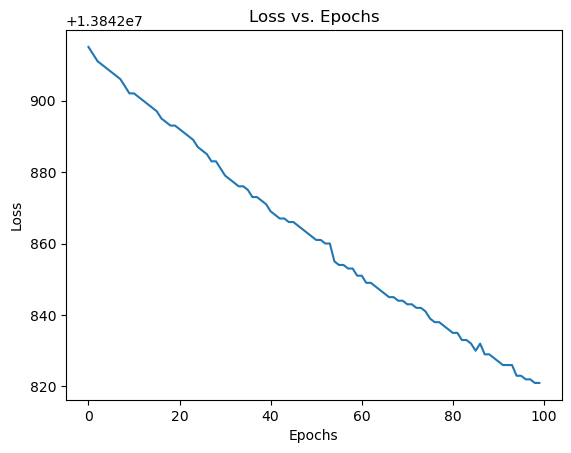

In [16]:
plt.plot(range(num_epochs), losses)
# plt.ylim(0,losses[0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.show()

In [27]:
# observations
# we barely learned anything (the error hardly went down)
# maybe, we just need more data, more epochs, maybe hyperparameters are severely wrong.

# evaluation
# the error 
# human interpretable error
# R-squared 1 - (squared difference between predicted and observed)/(squared difference between observed and avg(observed))
# RMSE - root mean squared error
# avg absolute difference between p_recall and predicted p_recall

# note about our priorities
# from the pov of the user
# is the experience of learning worse when you know everything or when you know nothing. 
# getting really easy questions (difficulty of remembering)
# getting really hard questions (difficulty of remembering)

# A. if our error is really big (cumulative error) because we are making a lot of small mistakes, then maybe thats ok
# B. if our error is really big because we predict perfectly a lot of the time, but when we make a mistake, its a very big mistake

# B is very bad. A is not so bad. p_recall is .5 and we predict .47, that's not bad.

# calculate the residuals - (predicted - actual)

# side note: if you have experience with ML, you will be wondering why we're training the model on all of our data
# we are supposed to leave some aside. don't worry, we'll do this later

# getting predictions
predicted_h_hat = model.forward(x)
predicted_p_recall = model.prediction(predicted_h_hat.squeeze(),delta)

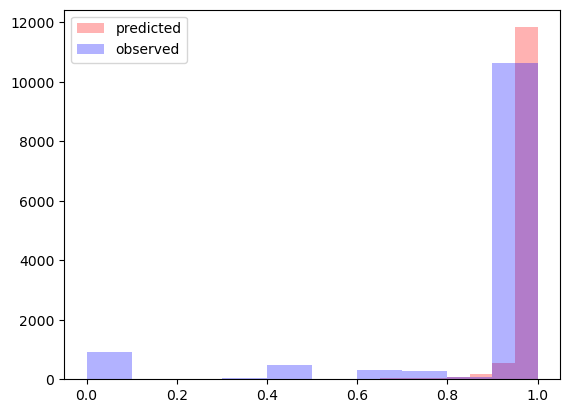

In [29]:
plt.figure()
plt.hist(predicted_p_recall.detach().numpy(),color = "red",alpha = .3,label = 'predicted')
plt.hist(p.detach().numpy(),color = "blue",alpha = .3,label = 'observed')
plt.legend()
plt.show()

In [ ]:
# observations
# model overestimates p_recall 